In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import importlib
import lumped_parameter_model
import utils 
import stats
importlib.reload(lumped_parameter_model)
importlib.reload(utils)
importlib.reload(stats)
from lumped_parameter_model import *
from utils import *
from stats import *
from scipy import optimize
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [34]:
#get data 
Q = convert_df_to_date_time(pd.read_csv('discharge_full_year_2018.csv'), 'Date').set_index('Date')
h = convert_df_to_date_time(pd.read_csv('2018_MRSW_year_FINAL.csv'), 'datetime').set_index('datetime')
r = convert_hourly_to_daily(convert_df_to_date_time(pd.read_csv('2017_2021_simulated_recharge_hourly.csv'), 'DATE'), 'DATE').set_index('DATE')
#clean data
Q = Q.dropna()
h = h.dropna()
r = r.dropna()
r = r[(r.index >= '2018-01-01') & (r.index <= '2018-12-31')] #get 2018 data only
h = h[h['gw_elev[m]'] > h['gw_elev[m]'].quantile(0.05)] #get rid of outliers



In [89]:
importlib.reload(lumped_parameter_model)
from lumped_parameter_model import *

A = 1.86e6 #m2
w = np.sqrt(A)
l = np.sqrt(A)
hk = 381
K1 = 500
kbar = K1 #m/d
b = 50
hs = 371.5 #m
sy = 0.1

model = Model(w =w, kbar = kbar, l = l, hs=hs, b=b, sy=sy, dt= dt)
param_model = ParametrizedKModel(w = w, l = l, b = b, hs =hs, sy = sy, dt = dt)


In [90]:
#model_inputs
rech = r[r.index.isin(h.index)]['RCH[m/day]'] #* 10
Q_val = Q[Q.index.isin(h.index)]['Q [m3/day]']
h_val = h['gw_elev[m]']
dt = np.array(h.index.diff().total_seconds()/86400)[1:]

In [23]:
cal_k = model.optimize_K_by_timestep(K_o = 100, Q = Q_val, h = h_val, r =rech, verbose = True)
cal_k = cal_k.join(Q_val)

-339.1329789146596 1361873.8601399173
962990.2714834602
-339.13297891463947 1361873.86041766
962990.2716798539
-339.13497355597565 1334241.14323783
943450.990598113
-339.13497355595587 1334241.143512741
943450.9907925045
-339.14274187821917 1226542.4483109228
867296.5157679212
-339.14274187820024 1226542.4485745055
867296.5159543024
-339.170451278858 841062.4315063569
594720.9970767723
-339.1704512788424 841062.4317246247
594720.9972311108
-339.2285214475876 -1.3602218183924955
239.87271621311126
-339.22852144758815 -1.3602218208509476
239.87271621311862
-339.2285214473793 -1.3602209128004095
239.87271621039636
-339.2285214473799 -1.360220915269272
239.87271621040378
-339.22852144654627 -1.3602172521655131
239.87271619942834
-339.22852144654684 -1.3602172546760176
239.87271619943587
-339.22852144321394 -1.3602019973610897
239.8727161538205
-339.2285214432145 -1.3602020000381614
239.8727161538285
-339.22852142988387 -1.3601311819059814
239.87271594361997
-339.2285214298844 -1.3601311852

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
lr = LinearRegression()
x = cal_k['Q [m3/day]'].values.reshape(-1, 1)
y = cal_k['K'].values
lr.fit(x,y)
slope = lr.coef_[0]
int = lr.intercept_
line_x =np.arange(0, 20000, 10) 
line_y = line_x* slope + int

In [87]:
pred = cal_k['Q [m3/day]'] * slope + int
r2 = r2_score(cal_k['K'], pred)

Text(0, 0.5, 'Calibrated K [m/d]')

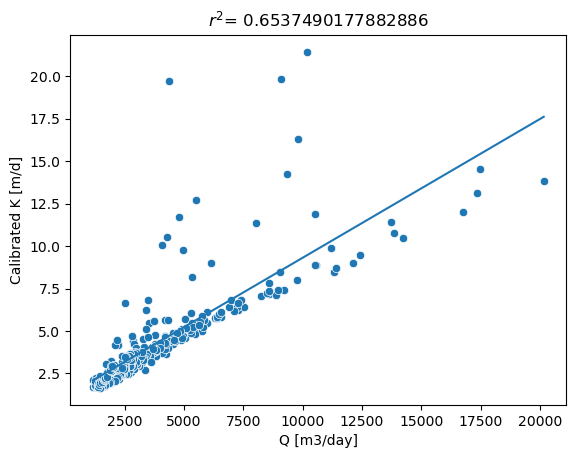

In [88]:
sns.scatterplot(cal_k, x = 'Q [m3/day]', y = 'K')
sns.lineplot(x = cal_k['Q [m3/day]'], y = pred)
plt.title (rf"$r^2$= {r2}")
plt.ylabel('Calibrated K [m/d]')

In [93]:
out = param_model.calibrate_linear_param_K(slope, int, rech, Q_val, h_val, weight_h = 0.1, weight_Q = 0.8, verbose = True)

set linear K function with slope 0.0008173791508505088 and intercept 1.136254290867171
0.0006738965
k = 2.146933105119599, qs: 1370.804764793479, qin: 1253.4474899999998, h: 377.8843130469097
0.0007152615
k = 2.2567215254958963, qs: 1440.7616678465438, qin: 1330.3863899999997, h: 377.88371963143743
0.0006866505
k = 2.3139028395095416, qs: 1477.1306981815874, qin: 1277.1699299999998, h: 377.882644573544
0.0006881155
k = 2.343630126642056, qs: 1495.8558110206122, qin: 1279.8948299999997, h: 377.88148349300087
0.0058021065
k = 2.3589356434739983, qs: 1505.350886988071, qin: 10791.91809, h: 377.9314112736622
0.0016023115
k = 2.3666967206055407, qs: 1522.1199970241848, qin: 2980.2993899999997, h: 377.939250947818
0.001124912
k = 2.380403441527378, qs: 1532.8015117044354, qin: 2092.33632, h: 377.9422591994755
0.001025097
k = 2.3891342889265186, qs: 1539.1422351619156, qin: 1906.6804199999997, h: 377.9442352112219
0.0009934789999999998
k = 2.3943170640819718, qs: 1542.9542331186474, qin: 1847

In [105]:
param_model.linear_k_q(slope, int)

set linear K function with slope 0.0008173791508505088 and intercept 1.136254290867171


In [94]:
param_model.linear_k_q(out.x[0], out.x[1])

set linear K function with slope 1.5165898136338503 and intercept 1.9929625673270421


In [54]:
param_model.linear_k_q(.01, 1)

set linear K function with slope 0.01 and intercept 1


In [106]:
cal_out = param_model.explicit_solve_over_time(len(dt), h_val.iloc[0], Q_val.iloc[0], rech, dt = dt)

In [51]:
cal_out['timestep']

0        1.0
1        2.0
2        3.0
3        4.0
4        5.0
       ...  
322    343.0
323    344.0
324    345.0
325    346.0
326    347.0
Name: timestep, Length: 327, dtype: float64

<Axes: xlabel='datetime', ylabel='k'>

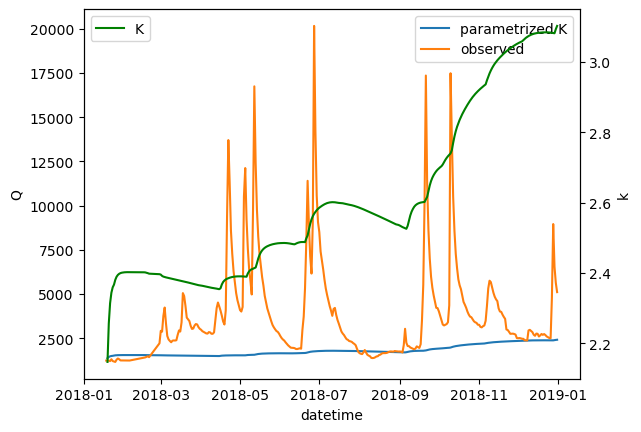

In [107]:
fig, ax = plt.subplots()
sns.lineplot(cal_out, x = h_val.index[1:], y = 'Q', label = 'parametrized K', ax = ax)
sns.lineplot(Q_val, label = 'observed',ax = ax)
# ax.set_ylim(0, 30000)
sns.lineplot(cal_out, x = h_val.index[1:], y = 'k', label = 'K', ax = ax.twinx(), color = 'green')



<Axes: xlabel='datetime', ylabel='k'>

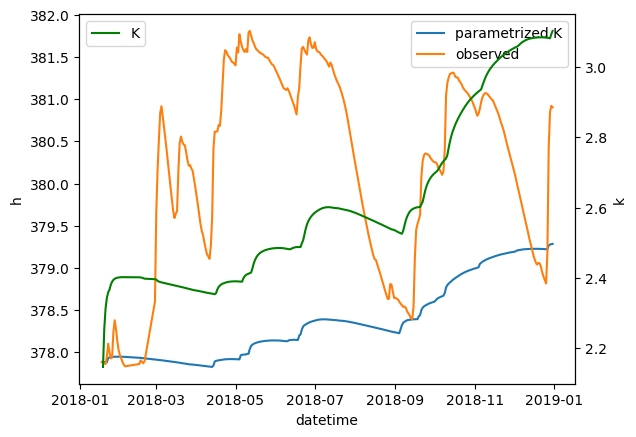

In [108]:
fig, ax = plt.subplots()
sns.lineplot(cal_out, x = h_val.index[1:], y = 'h', label = 'parametrized K', ax = ax)
sns.lineplot(h_val, label = 'observed', ax = ax)
sns.lineplot(cal_out, x = h_val.index[1:], y = 'k', label = 'K', ax = ax.twinx(), color = 'green')


<Axes: xlabel='datetime', ylabel='gw_elev[m]'>

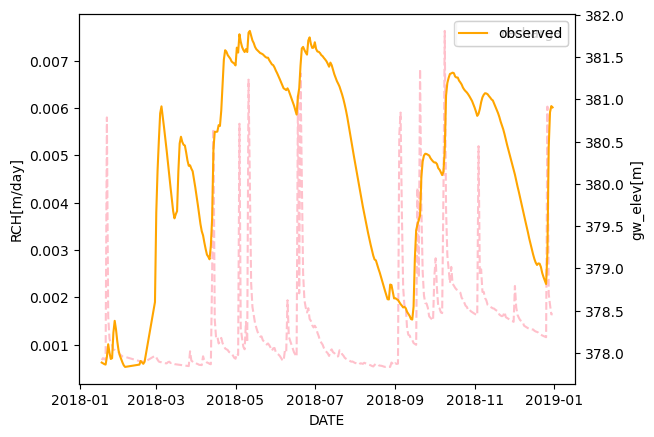

In [109]:
fig, ax = plt.subplots()
sns.lineplot(x = rech.index, y = rech, ax = ax, label = 'recharge', linestyle = '--', color = 'pink')
sns.lineplot(x = h_val.index, y = h_val, label = 'observed', ax = ax.twinx(), color = 'orange')


<Axes: xlabel='Date', ylabel='Q [m3/day]'>

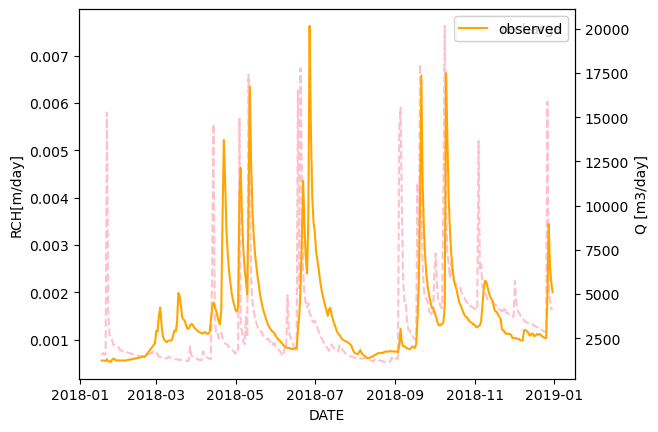

In [110]:
fig, ax = plt.subplots()
sns.lineplot(x = rech.index, y = rech, ax = ax, label = 'recharge', linestyle = '--', color = 'pink')
sns.lineplot(x = Q_val.index, y = Q_val, label = 'observed', ax = ax.twinx(), color = 'orange')


<Axes: xlabel='datetime', ylabel='h'>

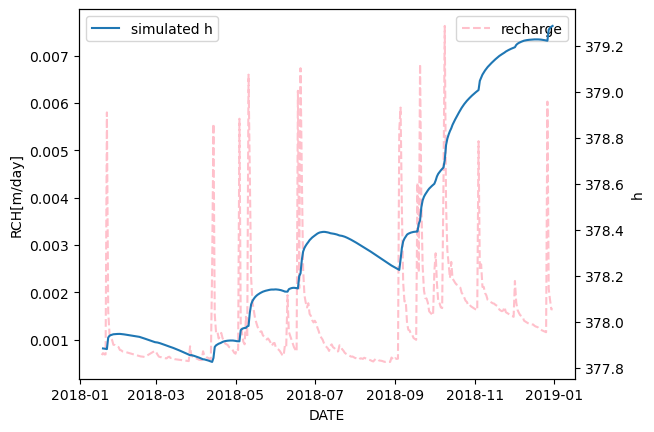

In [111]:
fig, ax = plt.subplots()
sns.lineplot(x = rech.index, y = rech, ax = ax, label = 'recharge', linestyle = '--', color = 'pink')
sns.lineplot(cal_out, x = h_val.index[1:], y = 'h', label = 'simulated h', ax = ax.twinx())

<Axes: xlabel='Q', ylabel='k'>

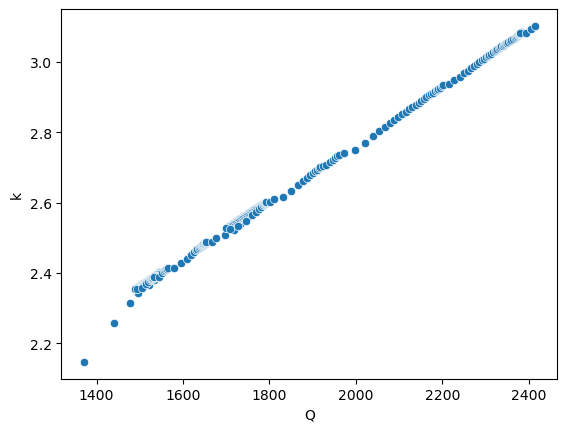

In [112]:
sns.scatterplot(cal_out, x = 'Q', y = 'k')

<Axes: xlabel='h', ylabel='k'>

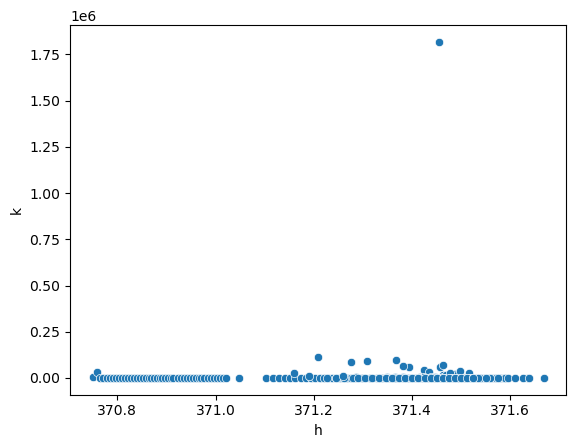

In [104]:
sns.scatterplot(cal_out, x = 'h', y = 'k')

# Residuals

In [117]:
cal_out.index = rech.index[1:]
all_results = cal_out.join(rech).join(Q_val).join(h_val)
all_results['Q_residual'] = all_results['Q [m3/day]'] - all_results.Q
all_results['h_residual'] = all_results['gw_elev[m]'] - all_results.h

<Axes: xlabel='DATE', ylabel='h'>

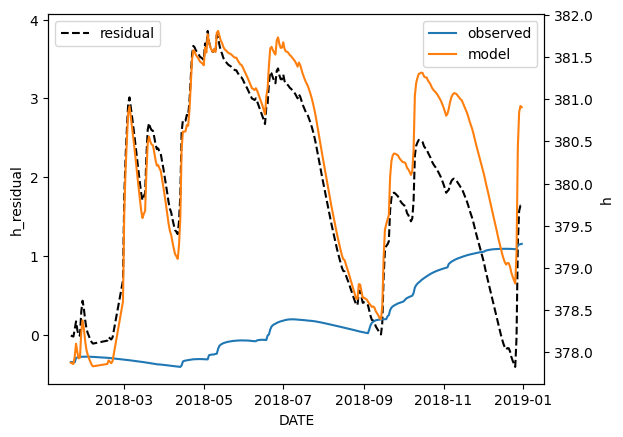

In [ ]:
fig, ax = plt.subplots()
twin = ax.twinx()
sns.lineplot(all_results, x = all_results.index, y = 'h_residual',ax = ax, color = 'black', linestyle = '--', label = 'residual')
ax.legend(loc = 'upper left')
sns.lineplot(all_results, x = all_results.index, y = 'h', ax = twin, label = 'model')
sns.lineplot(all_results, x = all_results.index, y = 'gw_elev[m]', ax = twin, label = 'observed')

<Axes: xlabel='DATE', ylabel='Q'>

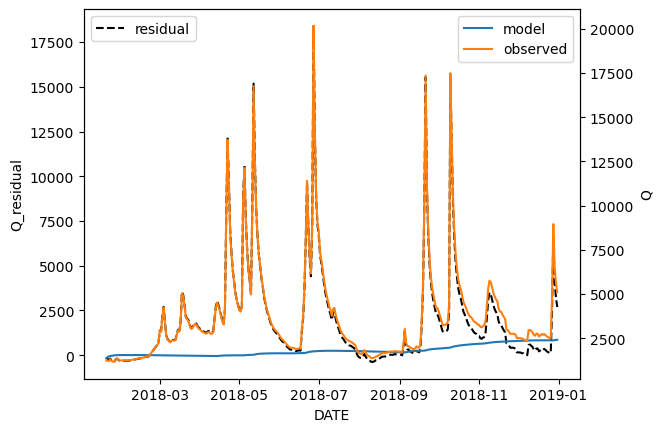

In [127]:
fig, ax = plt.subplots()
twin = ax.twinx()
sns.lineplot(all_results, x = all_results.index, y = 'Q_residual',ax = ax, color = 'black', linestyle = '--', label = 'residual')
ax.legend(loc = 'upper left')
sns.lineplot(all_results, x = all_results.index, y = 'Q', ax = twin, label = 'model')
sns.lineplot(all_results, x = all_results.index, y = 'Q [m3/day]', ax = twin, label = 'observed')

<Axes: xlabel='Q_residual', ylabel='Percent'>

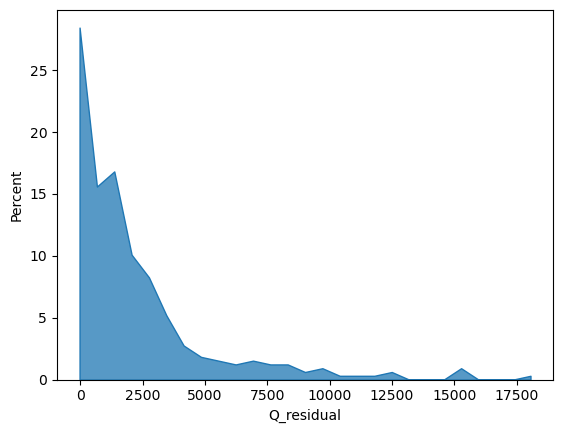

In [130]:
sns.histplot(all_results, x = 'Q_residual', element = 'poly', stat = 'percent')

<Axes: xlabel='h_residual', ylabel='Percent'>

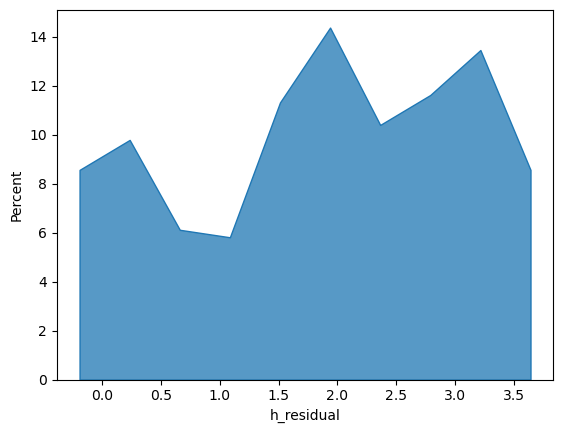

In [131]:
sns.histplot(all_results, x = 'h_residual', element = 'poly', stat = 'percent')

## Only looking at summer months

In [82]:
#model_inputs
start_date = '04-05-2018'
end_date = '07-01-2018'
rech = r[r.index.isin(h.index)]['RCH[m/day]'].loc[start_date:end_date] * 5
Q_val = Q[Q.index.isin(h.index)]['Q [m3/day]'].loc[start_date:end_date]
h_val = h['gw_elev[m]'].loc[start_date:end_date]
dt = np.array(h_val.index.diff().total_seconds()/86400)[1:]

In [83]:
out =param_model.explicit_solve_over_time(len(dt), h_val.iloc[0], Q_val.iloc[0], rech, dt = dt, verbose = True)

0.0028368825000000004
k = 3.4022120711767028, qs: 2701.160417098993, qin: 5276.60145, h: 379.4532704571661
0.0037688075
k = 3.344126498906552, qs: 2659.6742488779873, qin: 7009.981949999999, h: 379.47665920824744
0.0032898225
k = 3.310216569954025, qs: 2640.446948401703, qin: 6119.06985, h: 379.49536148191197
0.0032562675
k = 3.294500575417572, qs: 2634.0723002830478, qin: 6056.65755, h: 379.5137624778782
0.003107825
k = 3.289290070951375, qs: 2635.9589349447365, qin: 5780.554499999998, h: 379.5306689056473
0.0030604225
k = 3.290832166789111, qs: 2642.7583555537253, qin: 5692.385849999999, h: 379.54706475239163
0.0029672475
k = 3.296389871432762, qs: 2652.6262744547366, qin: 5519.080349999999, h: 379.56247579580855
0.0029272325000000003
k = 3.304455702604732, qs: 2664.209412057219, qin: 5444.65245, h: 379.5774244142921
0.01259313
k = 3.3139235177824338, qs: 2676.796672963267, qin: 23423.221799999996, h: 379.68896433432997
0.027815075
k = 3.324212082413353, qs: 2722.18541826317, qin: 51

<Axes: xlabel='datetime', ylabel='k'>

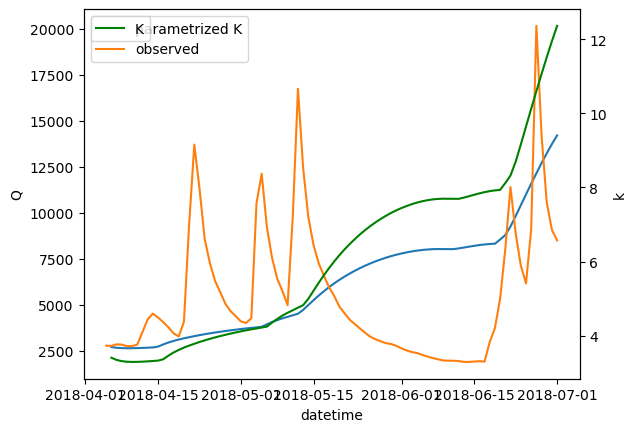

In [84]:
fig, ax = plt.subplots()
sns.lineplot(out, x = h_val.index[1:], y = 'Q', label = 'parametrized K', ax = ax)
sns.lineplot(Q_val, label = 'observed',ax = ax)
# ax.set_ylim(0, 30000)
sns.lineplot(out, x = h_val.index[1:], y = 'k', label = 'K', ax = ax.twinx(), color = 'green')

<Axes: xlabel='datetime', ylabel='k'>

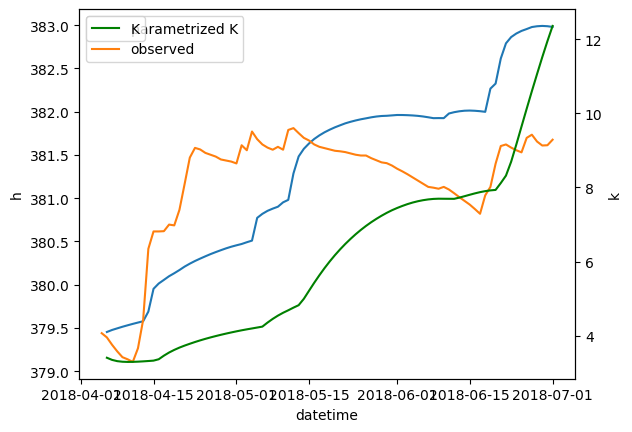

In [85]:
fig, ax = plt.subplots()
sns.lineplot(out, x = h_val.index[1:], y = 'h', label = 'parametrized K', ax = ax)
sns.lineplot(h_val, label = 'observed', ax = ax)
sns.lineplot(out, x = h_val.index[1:], y = 'k', label = 'K', ax = ax.twinx(), color = 'green')